In [2]:
import math
from re import A
import nltk as nt
from numpy import mean
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import word_tokenize
import pycountry as pyc
from nltk.stem import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from wordcloud import WordCloud


nt.download([
    "names",
    "stopwords",
    "vader_lexicon",
    "shakespeare",
    "crubadan"
])

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\chak1\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chak1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chak1\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\chak1\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!
[nltk_data] Downloading package crubadan to
[nltk_data]     C:\Users\chak1\AppData\Roaming\nltk_data...
[nltk_data]   Package crubadan is already up-to-date!


True

In [3]:
# Import english stopwords
stopwords = nt.corpus.stopwords.words("english")

# Object to detect languages of lyrics
tc = nt.classify.textcat.TextCat()

# Stemmer of words
ps = PorterStemmer()

# Retrieve datas
data = pd.read_csv("D:\Cours\Cours_M2\Projet\\10001-12000.csv")
emotions = pd.read_csv("D:\Cours\Cours_M2\Projet\\emotions.csv")

In [4]:
# Clean data
data = data[(data.Lyrics != "NAN")]
data["Lyrics"].astype(str)
data = data.dropna(how='any', axis=0)

# Slice the data for dev purposes
data=data[:500]

# Keep only english songs
for i,_ in enumerate(data):
    val = pyc.languages.get(alpha_3=data.iloc[i]["Lyrics"])
    if val != None and val.name != "English":
        data.drop(i)

In [5]:
# Tokenize the lyrics
def tokenize_lyrics_from_list(lyrics):
    new_data = list()
    for words in lyrics:
        new_data.append(word_tokenize(words))
    return new_data

In [6]:
# Filter the lyrics on tokenized lyrics
def remove_number_and_stopwords(lyrics):
    for words in lyrics:
        for word in words:
            if not(word.isalpha()) or word.lower() in stopwords:
                lyrics.remove(word)

In [7]:
# Filter the lyrics on tokenized lyrics
def remove_number_and_stopwords(lyrics):
    for words in lyrics:
        for word in words:
            if not(word.isalpha()) or word.lower() in stopwords:
                words.remove(word)

#Stem words of lyrics on tokenized lyrics
def stem_words(lyrics):
    new_data = list()
    for words in lyrics:
        lyrics_words = list()
        for word in words:
            lyrics_words.append(ps.stem(word))
        new_data.append(lyrics_words)
    return new_data

tokenized_data = tokenize_lyrics_from_list(data["Lyrics"])
remove_number_and_stopwords(tokenized_data)
stemed_data = stem_words(tokenized_data)

In [8]:
data["tokenized_clean_text"] = tokenized_data
data["tokenized_stemed_text"] = stemed_data
data.head()

,track,artist,seeds,number_of_emotion_tags,valence_tags,arousal_tags,dominance_tags,genre,Lyrics,tokenized_clean_text,tokenized_stemed_text
1,The Fun Machine Took A Shit And Died,Queens of the Stone Age,['eerie'],2,5.897955,5.062500,4.839318,hard rock,The Fun Machine Took a Shit & Died Lyrics Got ...,"[Fun, Machine, Took, Shit, Died, Lyrics, Got, ...","[fun, machin, took, shit, die, lyric, got, gun..."
2,Ear Wax,Bauhaus,['eerie'],2,4.240000,4.830000,4.260000,post-punk,Earwax LyricsHazy four o'clock shadows Commenc...,"[Earwax, LyricsHazy, four, shadows, Commence, ...","[earwax, lyricshazi, four, shadow, commenc, se..."
3,God Is Dead,Midtown,"['eerie', 'lonely']",2,2.913333,4.770000,3.523333,alternative rock,God Is Dead LyricsJust because we're abandoned...,"[God, Dead, LyricsJust, abandoned, n't, mean, ...","[god, dead, lyricsjust, abandon, n't, mean, we..."
4,Trøllabundin,Eivør Pálsdóttir,['eerie'],3,5.490000,4.633333,5.200000,folk,Trøllabundin LyricsTrøllabundin eri eg eri eg ...,"[Trøllabundin, LyricsTrøllabundin, eri, eg, er...","[trøllabundin, lyricstrøllabundin, eri, eg, er..."
5,Epiklesis II,Deathspell Omega,['eerie'],2,4.400000,4.575000,4.695000,black metal,Epiklesis II LyricsEcoutez les tres étouffé l...,"[Epiklesis, II, LyricsEcoutez, les, tres, étou...","[epiklesi, ii, lyricsecoutez, le, tre, étouffé..."


In [9]:
tokenized_filtered_stemed_data= list()
for a in tokenized_data:
    tokenized_filtered_stemed_data.append(stem_words(a))

In [10]:
# Normalize data
data[["arousal_tags","valence_tags"]] = StandardScaler().fit_transform(data[["arousal_tags","valence_tags"]])

In [11]:
emotion_words = dict()
emotion_words["joy"] = ["excited", "delighted", "blissful"]
emotion_words["anger"] = ["furious", "annoyed", "disgusted"]
emotion_words["sadness"] = ["dispointed", "depressed", "bored"]
emotion_words["pleasure"] = ["content", "serene", "relaxed"]

In [12]:
def determine_tag_by_vad(valence, arousal):
    valence = float(valence)
    arousal = float(arousal)
    if valence > 0:
        if arousal > 0:
            if arousal <= 0.25:
                return ["blissful","joy"]
            if 0.25 < arousal <= 0.75:
                return ["delighted","joy"]
            if arousal > 0.75:
                return ["excited","joy"]
        else:
            if arousal >= -0.25:
                return ["content","pleasure"]
            if  -0.25 > arousal >= -0.75:
                return ["serene","pleasure"]
            if arousal < -0.75:
                return ["relaxed","pleasure"]
    else:
        if arousal > 0:
            if arousal <= 0.25:
                return ["disgusted","anger"]
            if  0.25 < arousal <= 0.75:
                return ["annoyed","anger"]
            if arousal > 0.75:
                return ["furious","anger"]
        else:
            if arousal >= -0.25:
                return ["disapointed","sadness"]
            if -0.25 > arousal >= -0.75:
                return ["depressed","sadness"]
            if arousal < -0.75:
                return ["bored","sadness"]

In [13]:
tags = list()
main_tag = list()
for y in range(len(data)):
    tags.append(determine_tag_by_vad(data.iloc[y]["valence_tags"], data.iloc[y]["arousal_tags"])[0])
    main_tag.append(determine_tag_by_vad(data.iloc[y]["valence_tags"], data.iloc[y]["arousal_tags"])[1])
data.insert(len(data.columns), 'tag', tags)
data.insert(len(data.columns), 'main_tag', main_tag)

In [14]:
# To be able to analyze sentiment we need to detokenize data
detokenized_data = list()
for lyrics in stemed_data:
    detokenized_data.append(TreebankWordDetokenizer().detokenize(lyrics))

In [15]:
data["detokenized"] = detokenized_data
data.head()

,track,artist,seeds,number_of_emotion_tags,valence_tags,arousal_tags,dominance_tags,genre,Lyrics,tokenized_clean_text,tokenized_stemed_text,tag,main_tag,detokenized
1,The Fun Machine Took A Shit And Died,Queens of the Stone Age,['eerie'],2,1.706521,0.481493,4.839318,hard rock,The Fun Machine Took a Shit & Died Lyrics Got ...,"[Fun, Machine, Took, Shit, Died, Lyrics, Got, ...","[fun, machin, took, shit, die, lyric, got, gun...",delighted,joy,fun machin took shit die lyric got gun wanna t...
2,Ear Wax,Bauhaus,['eerie'],2,0.172041,0.231754,4.260000,post-punk,Earwax LyricsHazy four o'clock shadows Commenc...,"[Earwax, LyricsHazy, four, shadows, Commence, ...","[earwax, lyricshazi, four, shadow, commenc, se...",blissful,joy,earwax lyricshazi four shadow commenc seanc ni...
3,God Is Dead,Midtown,"['eerie', 'lonely']",2,-1.055823,0.167306,3.523333,alternative rock,God Is Dead LyricsJust because we're abandoned...,"[God, Dead, LyricsJust, abandoned, n't, mean, ...","[god, dead, lyricsjust, abandon, n't, mean, we...",disgusted,anger,god dead lyricsjust abandonn't mean we alon fa...
4,Trøllabundin,Eivør Pálsdóttir,['eerie'],3,1.328949,0.020506,5.200000,folk,Trøllabundin LyricsTrøllabundin eri eg eri eg ...,"[Trøllabundin, LyricsTrøllabundin, eri, eg, er...","[trøllabundin, lyricstrøllabundin, eri, eg, er...",blissful,joy,trøllabundin lyricstrøllabundin eri eg eri eg ...
5,Epiklesis II,Deathspell Omega,['eerie'],2,0.320125,-0.042153,4.695000,black metal,Epiklesis II LyricsEcoutez les tres étouffé l...,"[Epiklesis, II, LyricsEcoutez, les, tres, étou...","[epiklesi, ii, lyricsecoutez, le, tre, étouffé...",content,pleasure,epiklesi ii lyricsecoutez le tre étouffé le tr...


In [16]:
# Create a sentiment analyzer object and detect the valence of lyrics
sia = SentimentIntensityAnalyzer()
def is_positive(lyrics: str) -> bool:
    return sia.polarity_scores(lyrics)["compound"] > 0.05

def is_negative(lyrics: str) -> bool:
    return sia.polarity_scores(lyrics)["compound"] < -0.05

def is_neutral(lyrics: str) -> bool:
    return sia.polarity_scores(lyrics)["compound"] > -0.05 and sia.polarity_scores(lyrics)["compound"] < 0.05

In [17]:
# Determine compound of lyrics
# firts we split the lyrics in 4 parts then we check the coumpound value for each part 
# then we mean all compound values to determine the overall coumpound af the lyrics
def determine_lyrics_compound(lyrics):
    size_of_parts = math.ceil(len(lyrics) / 4)
    split_parts = list()
    split_parts.append(lyrics[:size_of_parts])
    split_parts.append(lyrics[size_of_parts:size_of_parts*2])
    split_parts.append(lyrics[:size_of_parts*2:size_of_parts*3])
    split_parts.append(lyrics[size_of_parts*3:])

    scores = list()
    for values in split_parts:
        scores.append(sia.polarity_scores(values)["compound"])
    return scores

compound = list()
for x in range(len(data)):
    compound.append(mean(determine_lyrics_compound(data.iloc[x]["Lyrics"])))
data.insert(len(data.columns), 'mean_compound', compound)
data.head()

,track,artist,seeds,number_of_emotion_tags,valence_tags,arousal_tags,dominance_tags,genre,Lyrics,tokenized_clean_text,tokenized_stemed_text,tag,main_tag,detokenized,mean_compound
1,The Fun Machine Took A Shit And Died,Queens of the Stone Age,['eerie'],2,1.706521,0.481493,4.839318,hard rock,The Fun Machine Took a Shit & Died Lyrics Got ...,"[Fun, Machine, Took, Shit, Died, Lyrics, Got, ...","[fun, machin, took, shit, die, lyric, got, gun...",delighted,joy,fun machin took shit die lyric got gun wanna t...,0.231025
2,Ear Wax,Bauhaus,['eerie'],2,0.172041,0.231754,4.260000,post-punk,Earwax LyricsHazy four o'clock shadows Commenc...,"[Earwax, LyricsHazy, four, shadows, Commence, ...","[earwax, lyricshazi, four, shadow, commenc, se...",blissful,joy,earwax lyricshazi four shadow commenc seanc ni...,-0.153100
3,God Is Dead,Midtown,"['eerie', 'lonely']",2,-1.055823,0.167306,3.523333,alternative rock,God Is Dead LyricsJust because we're abandoned...,"[God, Dead, LyricsJust, abandoned, n't, mean, ...","[god, dead, lyricsjust, abandon, n't, mean, we...",disgusted,anger,god dead lyricsjust abandonn't mean we alon fa...,-0.099250
4,Trøllabundin,Eivør Pálsdóttir,['eerie'],3,1.328949,0.020506,5.200000,folk,Trøllabundin LyricsTrøllabundin eri eg eri eg ...,"[Trøllabundin, LyricsTrøllabundin, eri, eg, er...","[trøllabundin, lyricstrøllabundin, eri, eg, er...",blissful,joy,trøllabundin lyricstrøllabundin eri eg eri eg ...,0.000000
5,Epiklesis II,Deathspell Omega,['eerie'],2,0.320125,-0.042153,4.695000,black metal,Epiklesis II LyricsEcoutez les tres étouffé l...,"[Epiklesis, II, LyricsEcoutez, les, tres, étou...","[epiklesi, ii, lyricsecoutez, le, tre, étouffé...",content,pleasure,epiklesi ii lyricsecoutez le tre étouffé le tr...,0.068300


In [18]:
valence = list()
for a in range(len(data)):
    if data.iloc[a]["mean_compound"] > 0.05:
        valence.append("positive")
    elif data.iloc[a]["mean_compound"] < -0.05:
        valence.append("negative")
    elif - 0.05 < data.iloc[a]["mean_compound"] < 0.05:
        valence.append("neutral")
    else:
        valence.append("nan")
data["valence"] = valence
data.head()

,track,artist,seeds,number_of_emotion_tags,valence_tags,arousal_tags,dominance_tags,genre,Lyrics,tokenized_clean_text,tokenized_stemed_text,tag,main_tag,detokenized,mean_compound,valence
1,The Fun Machine Took A Shit And Died,Queens of the Stone Age,['eerie'],2,1.706521,0.481493,4.839318,hard rock,The Fun Machine Took a Shit & Died Lyrics Got ...,"[Fun, Machine, Took, Shit, Died, Lyrics, Got, ...","[fun, machin, took, shit, die, lyric, got, gun...",delighted,joy,fun machin took shit die lyric got gun wanna t...,0.231025,positive
2,Ear Wax,Bauhaus,['eerie'],2,0.172041,0.231754,4.260000,post-punk,Earwax LyricsHazy four o'clock shadows Commenc...,"[Earwax, LyricsHazy, four, shadows, Commence, ...","[earwax, lyricshazi, four, shadow, commenc, se...",blissful,joy,earwax lyricshazi four shadow commenc seanc ni...,-0.153100,negative
3,God Is Dead,Midtown,"['eerie', 'lonely']",2,-1.055823,0.167306,3.523333,alternative rock,God Is Dead LyricsJust because we're abandoned...,"[God, Dead, LyricsJust, abandoned, n't, mean, ...","[god, dead, lyricsjust, abandon, n't, mean, we...",disgusted,anger,god dead lyricsjust abandonn't mean we alon fa...,-0.099250,negative
4,Trøllabundin,Eivør Pálsdóttir,['eerie'],3,1.328949,0.020506,5.200000,folk,Trøllabundin LyricsTrøllabundin eri eg eri eg ...,"[Trøllabundin, LyricsTrøllabundin, eri, eg, er...","[trøllabundin, lyricstrøllabundin, eri, eg, er...",blissful,joy,trøllabundin lyricstrøllabundin eri eg eri eg ...,0.000000,neutral
5,Epiklesis II,Deathspell Omega,['eerie'],2,0.320125,-0.042153,4.695000,black metal,Epiklesis II LyricsEcoutez les tres étouffé l...,"[Epiklesis, II, LyricsEcoutez, les, tres, étou...","[epiklesi, ii, lyricsecoutez, le, tre, étouffé...",content,pleasure,epiklesi ii lyricsecoutez le tre étouffé le tr...,0.068300,positive


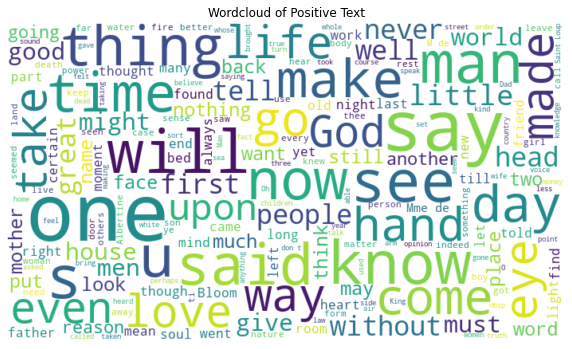

In [24]:
positive = " ".join(data[data.valence == 'positive']["Lyrics"].values)

w = WordCloud(width = 700, height = 400, random_state = 10, max_font_size = 100, background_color = 'white').generate(positive)

plt.figure(figsize = (10,6))
plt.imshow(w, interpolation = "bilinear")
plt.title("Wordcloud of Positive Text")
plt.axis('off')
plt.show()

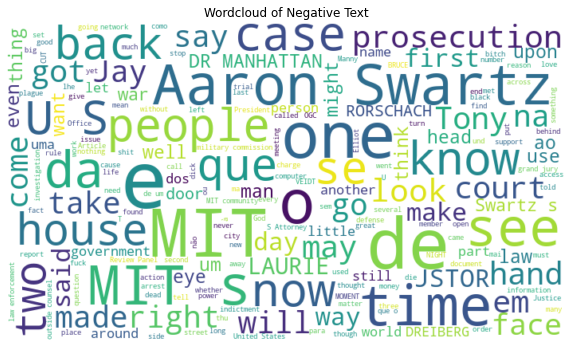

In [25]:
negative = " ".join(data[data.valence == 'negative']["Lyrics"].values)

w = WordCloud(width = 700, height = 400, random_state = 10, max_font_size = 100, background_color = 'white').generate(negative)

plt.figure(figsize = (10,6))
plt.imshow(w, interpolation = "bilinear")
plt.title("Wordcloud of Negative Text")
plt.axis('off')
plt.show()

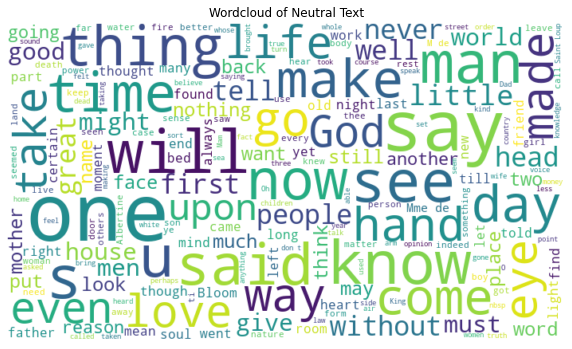

In [26]:
neutral = " ".join(data[data.valence == 'neutral']["Lyrics"].values)

w = WordCloud(width = 700, height = 400, random_state = 10, max_font_size = 100, background_color = 'white').generate(positive)

plt.figure(figsize = (10,6))
plt.imshow(w, interpolation = "bilinear")
plt.title("Wordcloud of Neutral Text")
plt.axis('off')
plt.show()

In [20]:
# Determine bags of positive/negative words base on valence of data
def create_set_of_words_by_frequency(values, list):
    fd = nt.FreqDist(values)
    for value in fd.most_common():
        if value[0].lower() not in stopwords and value[1] > 12:
            list.append(value[0].lower())

positive_words = list()
negative_words = list()
for i in range(0, len(stemed_data)):
    if is_negative(detokenized_data[i]):
        create_set_of_words_by_frequency(stemed_data[i], negative_words)

    if is_positive(detokenized_data[i]):
        create_set_of_words_by_frequency(stemed_data[i], positive_words)

positive_fd = nt.FreqDist(positive_words)
negative_fd = nt.FreqDist(negative_words)
intersection = set(positive_fd).intersection(negative_fd)

for value in intersection:
    if value in (positive_words and negative_words):
        positive_words.remove(value)
    if value in negative_words:
        negative_words.remove(value)

top_100_positive = {word for word, count in positive_fd.most_common(100)}
top_100_negative = {word for word, count in negative_fd.most_common(100)}

'# Determine bags of positive/negative words base on valence of data\ndef create_set_of_words_by_frequency(values, list):\n    fd = nt.FreqDist(values)\n    for value in fd.most_common():\n        if value[0].lower() not in stopwords and value[1] > 12:\n            list.append(value[0].lower())\n\npositive_words = list()\nnegative_words = list()\nfor i in range(0, len(stemed_data)):\n    if is_negative(detokenized_data[i]):\n        create_set_of_words_by_frequency(stemed_data[i], negative_words)\n\n    if is_positive(detokenized_data[i]):\n        create_set_of_words_by_frequency(stemed_data[i], positive_words)\n\npositive_fd = nt.FreqDist(positive_words)\nnegative_fd = nt.FreqDist(negative_words)\nintersection = set(positive_fd).intersection(negative_fd)\n\nfor value in intersection:\n    if value in (positive_words and negative_words):\n        positive_words.remove(value)\n    if value in negative_words:\n        negative_words.remove(value)\n\ntop_100_positive = {word for word, co